In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
import warnings
from torch import nn

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [3]:
class ManyToyModels(nn.Module):
    def __init__(self, m, n, num_models, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_models, m, n) * 1.5, requires_grad=True)
        self.bias = nn.Parameter(torch.randn(num_models, n, 1) * 0.5, requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU

    def forward(self, x):
        hidden = self.weights @ x
        final = torch.transpose(self.weights, -2, -1) @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class MSE_Multiple_models(nn.Module):
    def __init__(self):
        super(MSE_Multiple_models, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0)
        return torch.sum(sub_total * importance)

In [7]:
sparsity_rows = 1000
importance_rows = 100
probs = torch.repeat_interleave((torch.arange(0, sparsity_rows) / sparsity_rows), 2 * importance_rows)
probs = probs.reshape(sparsity_rows * importance_rows, 1, 2)
losses = []

def train_1000_models(model, num_models, epochs, total_batchs, batch_size, loss_fn, optimizer, importance):

    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            # calculating sparsity based on model
            rand_tensor = torch.rand(sparsity_rows * importance_rows, 1, 2)
            sparsity_tensor = (probs > rand_tensor).float()

            x = torch.rand(batch_size, num_models, 2, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()  / (total_batchs * batch_size)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total)
        loss_total = 0

In [11]:
model_test = ManyToyModels(1, 2, 100000, True).to(device)

In [12]:
NUM_EPOCHS = 6
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 64
LEARNING_RATE = 1e-2

In [13]:
first_feature_importance = torch.ones(100000, 1)
second_feature_importance = ((torch.arange(100)).repeat(1000, 1) / 10).reshape(100000, 1)
IMPORTANCE = torch.stack((first_feature_importance, second_feature_importance), dim=1).to(device)

In [14]:
optimizer = torch.optim.Adam(model_test.parameters(), lr=LEARNING_RATE)
loss_func = MSE_Multiple_models()
num_models = 100000

train_1000_models(model_test, num_models, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE)

(EPOCH: 1) --> loss: 261430.64399218743
(EPOCH: 2) --> loss: 39476.42894531248
(EPOCH: 3) --> loss: 34422.455558593705
(EPOCH: 4) --> loss: 31934.44703125001
(EPOCH: 5) --> loss: 30542.95341601563
(EPOCH: 6) --> loss: 29769.411111328154


In [17]:
len(losses)

6000

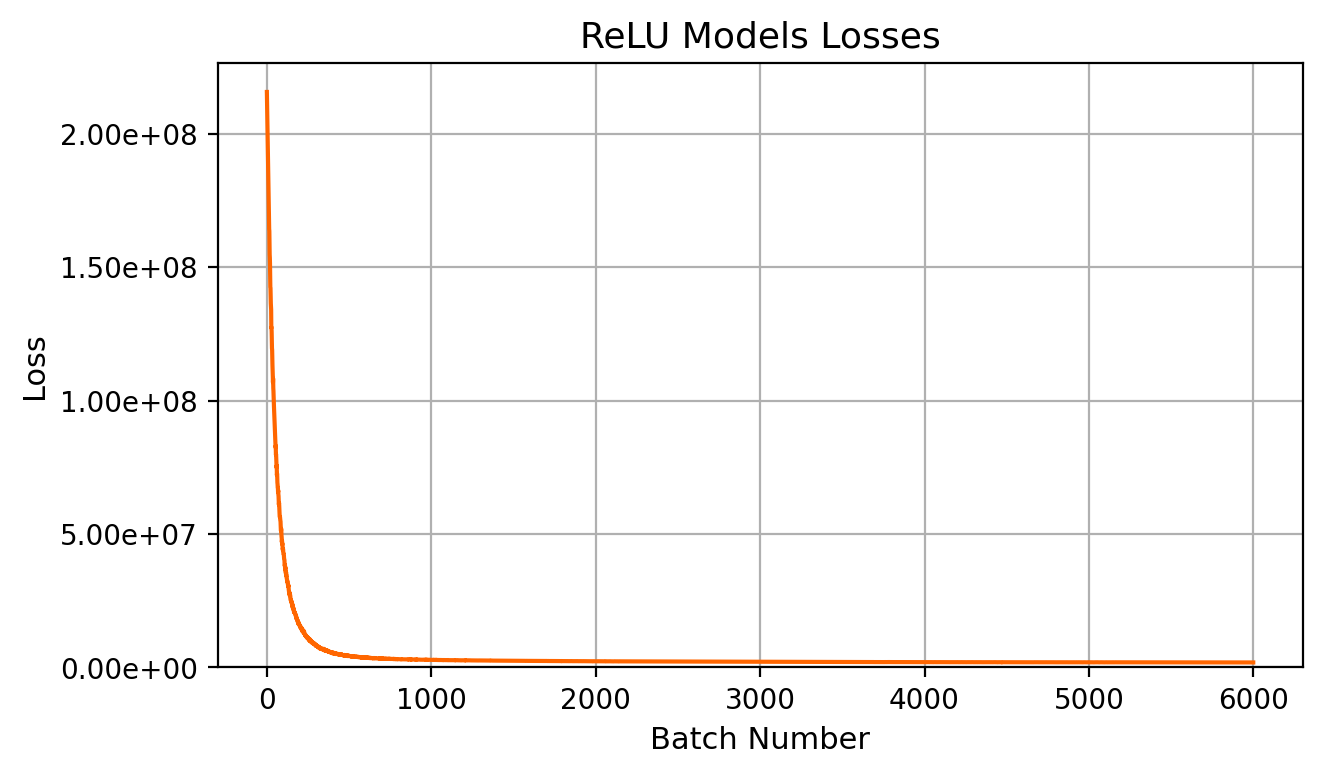

In [43]:
import matplotlib.ticker as ticker

def custom_formatter(x, pos):
    return f'{int(x):.2e}'

# Plotting the data
plt.figure(figsize=(7, 4), dpi=200)
plt.plot(losses, color=(1, .4, 0))
plt.title('ReLU Models Losses', fontsize=13)
plt.xlabel('Batch Number', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True)

plt.ylim(bottom=0)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

plt.show()